In [126]:
import geopandas as gpd
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import pandas as pd

pd.options.mode.copy_on_write = True

In [127]:
def calculate_auto_offset(row):
    """Automatically compute label offsets based on centroid position."""
    lon = row.geometry.centroid.x
    lat = row.geometry.centroid.y

    # Default offsets
    dx, dy = 0, 0

    # If island nations (Caribbean box)
    if -90 < lon < -55 and 0 < lat < 30:
        if lat > 18:  # Bahamas, Antigua etc
            dx, dy = -5, 8
        elif lat > 12:  # Barbados, Dominica, etc
            dx, dy = -5, 5
        else:  # St Lucia, St Vincent, Grenada etc
            dx, dy = -5, -5
    else:
        dx, dy = 0, 0  # mainland countries: no shift

    return dx, dy

In [128]:
# Resilience fill colors (lighter for polygons)
fill_colors = {
    1: '#a7d7c5',  # pastel green
    2: '#f4b183',  # pastel orange
    3: '#e79999'   # pastel red
}

# Resilience text colors (dark for font annotations)
font_colors = {
    1: '#006400',
    2: '#cc5500',
    3: '#8b0000'
}

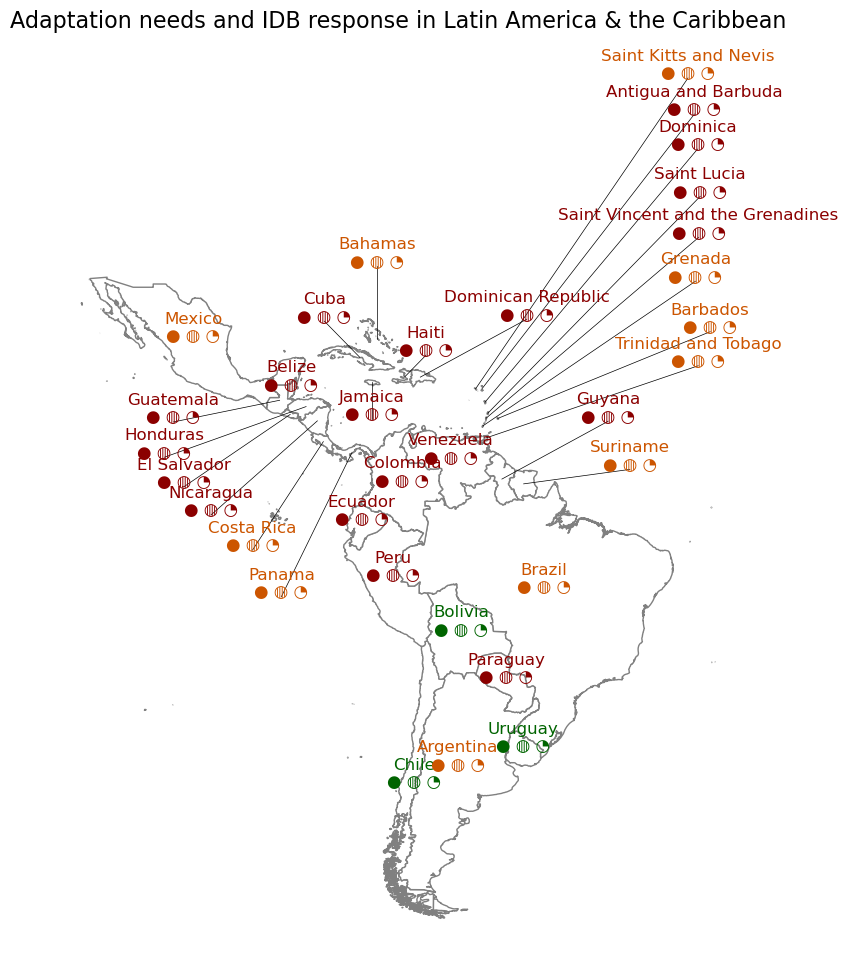

In [138]:

# Use Cartopy to load Natural Earth data (fully programmatic, no manual download)
shapefile_path = shpreader.natural_earth(resolution='10m',
                                         category='cultural',
                                         name='admin_0_countries')

# Read the shapefile with GeoPandas
world = gpd.read_file(shapefile_path)

# Define Latin America & Caribbean ISO3 codes (expanded to include Caribbean islands)
lac_iso = [
    'ARG', 'BLZ', 'BOL', 'BRA', 'CHL', 'COL', 'CRI', 'CUB', 'DOM',
    'ECU', 'SLV', 'GTM', 'GUY', 'HTI', 'HND', 'JAM', 'MEX', 'NIC',
    'PAN', 'PRY', 'PER', 'SUR', 'TTO', 'URY', 'VEN',
    'ATG', 'BRB', 'BHS', 'DMA', 'GRD', 'KNA', 'LCA', 'VCT'
]

# Filter to only LAC countries
lac = world[world['ISO_A3'].isin(lac_iso)]

# Create example resilience need scores (replace with your real data)
resilience_needs = {
    'ARG': 2, 'BLZ': 3, 'BOL': 1, 'BRA': 2, 'CHL': 1, 'COL': 3, 'CRI': 2,
    'CUB': 3, 'DOM': 3, 'ECU': 3, 'SLV': 3, 'GTM': 3, 'GUY': 3, 'HTI': 3,
    'HND': 3, 'JAM': 3, 'MEX': 2, 'NIC': 3, 'PAN': 2, 'PRY': 3, 'PER': 3,
    'SUR': 2, 'TTO': 2, 'URY': 1, 'VEN': 3, 'ATG': 3, 'BRB': 2, 'BHS': 2,
    'DMA': 3, 'GRD': 2, 'KNA': 2, 'LCA': 3, 'VCT': 3
}

# Merge resilience data into GeoDataFrame
lac['resilience'] = lac['ISO_A3'].map(resilience_needs)
test = lac['ISO_A3'].map(resilience_needs).map(fill_colors)

# Manual offsets for problem countries
manual_offsets = {
    'ATG': (30, 38),                # Antigua and Barbuda
    'BHS': (0, 10),                 # Bahamas
    'BRB': (30, 12),                 # Barbados
    'CRI': (-10, -15),             # Costa Rica
    'CUB': (-5, 5),
    'DOM': (15, 8),                 # Dominican Republic
    'DMA': (30, 35),                # Dominica
    'GRD': (30, 20),                # Grenada
    'GTM': (-15, -3),
    'GUY': (15, 8),
    'HND': (-20, -7),
    'HTI': (3, 3),
    'JAM': (0, -5),
    'KNA': (30, 43),                 # St. Kitts and Nevis
    'LCA': (30, 30),                # Saint Lucia
    'NIC': (-15, -13),             # Nicaragua
    'PAN': (-10, -20),
    'SLV': (-15, -10),
    'SUR': (15, 2),
    'TTO': (30, 10),
    'VCT': (30, 25),                # Saint Vincent and Grenadines
}

# Plot
fig, ax = plt.subplots(figsize=(14, 12))

# Color by resilience need
#lac.plot(ax=ax, color=test, edgecolor='gray')
# Color black and white
lac.plot(ax=ax, edgecolor='gray', color='white')

# Example icons per country (replace with real values)
icons = {
    'ARG': '● ◍ ◔', 'BRA': '● ◍ ◔', 'BOL': '● ◍ ◔',
    'MEX': '● ◍ ◔', 'HTI': '● ◍ ◔'
}
# Default icons for all others
default_icons = '● ◍ ◔'

# Annotate country name + icons
for idx, row in lac.iterrows():

    country_name = row['NAME_LONG']
    iso_name = row['ISO_A3']
    icon_text = icons.get(iso_name, default_icons)
    centroid = row['geometry'].centroid
    resilience_need = resilience_needs.get(iso_name, 0)

    show_iso_name = False
    if show_iso_name:
        label_text =  f"{country_name} ({iso_name})\n{icon_text}"
    else:
        label_text = f"{country_name}\n{icon_text}"

    if iso_name in manual_offsets:

        dx, dy = manual_offsets[iso_name]
        label_x = centroid.x + dx
        label_y = centroid.y + dy

        plt.annotate(
            label_text,
            xy=(label_x, label_y),
            ha='center', fontsize=12,
            color=font_colors[resilience_need]
        )

        # Draw leader line
        plt.plot([centroid.x, label_x], [centroid.y, label_y], color='black', linewidth=0.5)

    else:

        plt.annotate(
            label_text,
            xy=(centroid.x, centroid.y),
            ha='center', fontsize=12,
            color=font_colors[resilience_need]
        )

plt.title("Adaptation needs and IDB response in Latin America & the Caribbean", fontsize=16)
plt.axis('off')
plt.savefig("map.png", dpi=300)
plt.show()